## Import Libraries


In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from mpl_toolkits import mplot3d


# Linear Discriminant Analysis: Assumptions

A common implicit assumption we make in lots of machine learning algorithms is that if two examples have similar features then they will have similar labels; an algorithm where this assumption is particularly clear is the K-nearest neighbours, where we search for the K nearest examples to the example we're interested in and aggregate the labels of those examples to arrive at our prediction.

In training an Linear Discriminant Analysis model we make a similar, but subtly different, assumption: We assume that if two examples have the same label, then they will have similar features. More concretely, if two examples have the same label, we assume that their features were generated by the same random process; additionally, if two examples have different labels, then they were generated by different random processes.

In Linear Discriminant Analysis, we assume that the random process used to generate the features can be well modelled by a Multivariate Normal distribution and the model training equates to finding the best set of parameters for each normal distribution and the class probabilities for each label. 



# Generative Process

Let's write out the above in more mathematical language, and add a little bit more detail:

Suppose we have a dataset $D = \{(X_1, Y_1),..., (X_n, Y_n)\}$ of examples to train our model, where $X_i \in \mathbb{R}^p$ is a feature vector and $Y_i \in \{0,1,...,K-1\}$ is the corresponding label. When we have an example where we don't know what the label is and we're trying to predict it from the features, we want to compute $\mathbb{P}(Y = k | X = x)$ for each $k \in \{0,1,..., K - 1\}$ and we assign the label which has the highest probability - i.e. when faced with the question of what label to predict, we choose the one which we think is most likely, which makes intuitive sense.


Now how do we compute $\mathbb{P}(Y = k | X = x)$ for each $k \in \{0,1,..., K - 1\}$? By Bayes' rule, we have that:

$$\mathbb{P}(Y = k | X = x) = \frac{\mathbb{P}(X = x | Y = k)\mathbb{P}(Y = k)}{\mathbb{P}(X = x)}$$

(where we're being slightly sloppy with notation and using $\mathbb{P}$ to denote continuous probability density for $X$ - if this statement doesn't make any sense, don't worry about it!)

So now our task has shifted from computing $\mathbb{P}(Y = k | X = x)$ for each $k \in \{0,1,..., K - 1\}$ to computing $\frac{\mathbb{P}(X = x | Y = k)\mathbb{P}(Y = k)}{\mathbb{P}(X = x)}$ for each value of $k$. This initially looks much more complicated but we'll see that we can simplify things quite a lot.

The first thing we can do to make our lives easier is notice that the denominator $\mathbb{P}(X = x)$ is independent of $k$ - it will be the same for each value of $k$, so choosing the value of $k$ which maximises $\frac{\mathbb{P}(X = x | Y = k)\mathbb{P}(Y = k)}{\mathbb{P}(X = x)}$ is equivalent to choosing the value of $k$ which maximises $\mathbb{P}(X = x | Y = k)\mathbb{P}(Y = k)$ - in other words, we can ignore $\mathbb{P}(X = x)$ from now on.

Next we're going to use the LDA assumption we mentioned in the section above: that each label corresponds to a random process used to generate the features, and that we can use a Multivariate Normal distribution to approximate that random process. With Linear Discriminant Analysis it's important to note that although the mean of each Normal distribution will be different, we assume that each Normal distribution has the same covariance matrix (a related method called Quadratic Discriminant Analysis relaxes this assumption)

Written another way, we specify that $\mathbb{P}(X = x|Y = k) = N(x; \mu_k, \Sigma)$, where $N(x; \mu_k, \Sigma)$ is the probability density function of a normal distribution with mean vector $\mu_k$ and covariance matrix $\Sigma$ - this function can easily be evaluated in python, so if we know the parameters $\mu_k$ and $\Sigma$, and we know $\pi_k = \mathbb{P}(Y = k)$, then we can evaluate $\mathbb{P}(X = x | Y = k)\mathbb{P}(Y = k)$ for each $k$ and make our prediction.

## Fitting our LDA model

In order to use our LDA model, we need to know the parameters for the class probabilities, $\pi_0,..., \pi_{K-1}$, the mean vectors $\mu_0,..., \mu_{K-1}$ and the shared covariance matrix $\Sigma$. As usual, we don't know what these parameters are, so we have to estimate them from the training data. We'll estimate them using Maximum Likelihood Estimation - i.e we choose the parameters which have the best chance of generating the data we actually have. 

The equations for MLE are written below.

## Generate Data

In [2]:
#Dataset will be a mixture of Gaussians but two of the clusters will have substantial overlap
modelParameters = {'mu':[[-2,1], [0.2, -1], [0,1]], #Cluster means (2D)
                   'pi':[0.2, 0.35, 0.45], #Probability that a given point will belong to a particular cluster
                   'sigma':0.8, #Shared, known standard deviation
                   'n':500} 

#Here, we assume that each separate cluster has a common, known covariance matrix, sigma*I. 
#We can relax this assumption so that we must also estimate the covariance matrix parameters (can be done by Maximum Likelihood)
#Dropping the assumption of a shared covariance matrix leads to a different algorithm called Quadratic Discriminant Analysis

#Check that pi sums to 1
if np.sum(modelParameters['pi']) != 1:
    print('Mixture weights must sum to 1!')
    
data = []

#determine which mixture each point belongs to

def generateLabels(n, pi):
    #Generate n realisations of a categorical distribution given the parameters pi
    unif = np.random.uniform(size = n) #Generate uniform random variables
    labels = [(u < np.cumsum(pi)).argmax() for u in unif] #assign cluster
    return labels

#Given the labels, generate from the corresponding normal distribution

def generateDataset(labels, params):
        
    normalSamples = []
    for label in labels:
        
        #Select Parameters
        mu = params['mu'][label]
        Sigma = np.diag([params['sigma']**2]*len(mu))
        
        
        #sample from multivariate normal
        samp = np.random.multivariate_normal(mean = mu, cov = Sigma, size = 1)
        normalSamples.append(samp)
        
    normalSamples = np.reshape(normalSamples, (len(labels), len(params['mu'][0])))
    
    
    dataFeatures = pd.DataFrame(normalSamples)
    dataFeatures.columns = [f'X{i}' for i in range(len(params['mu'][0]))] 

    dataTarget = pd.DataFrame(labels)
    dataTarget.columns = ['Y']

    data = pd.concat([dataFeatures, dataTarget], axis = 1)
    return data
        

In [3]:
labels = generateLabels(modelParameters['n'], modelParameters['pi'])
data = generateDataset(labels, modelParameters)

In [4]:
data.head() #Quick look at the first few examples

X0        X1  Y
0 -1.017595  0.026363  0
1  0.541415 -0.466113  1
2  0.162193 -1.560205  1
3 -2.440211  0.594391  0
4 -0.405935  0.401683  2

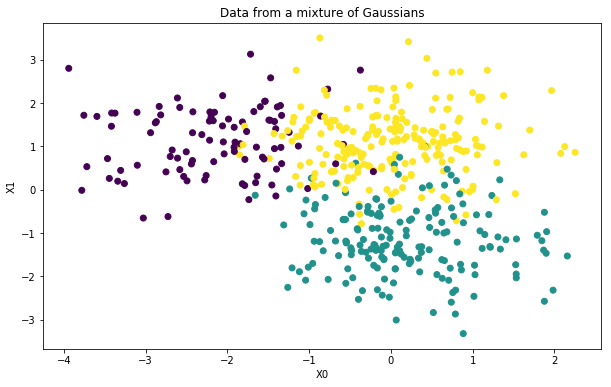

In [5]:
plt.figure(figsize=(10,6))
plt.scatter(data['X0'], data['X1'] ,c = data['Y'])
plt.xlabel('X0')
plt.ylabel('X1')
plt.title('Data from a mixture of Gaussians')
plt.show()

## Intuition: Why do we need to calculate the class probabilities? Why can't we just assign each point to the nearest cluster?

In the case where we have equivalent class probabilities (e.g. if we were interested in classifying someone as male/female based on certain features), then the class probabilities don't play any role in classifying examples, but when there is a big class imbalance it makes sense to incorporate this information. Consider the following example:

Suppose we were predicting whether a patient had a rare illness based on the results of a clinical test and we knew that approximately 0.01\% of the population had the condition. When doing our LDA parameter estimation, we found that the average test score for participants with the condition was 25 and the average score for healthy patients was 15. Then suppose that a new patient returned a score of 20.2; under the assumption of a common covariance matrix, 20.2 is more likely to be generated by a Normal Distribution with a mean of 25 than one of 15, so if the class probabilities were equal, or we didn't incorporate them, then we would conclude that this patient had the condition. However, if we knew that only 1 in 1000 people had this condition and the likelihood of their score was roughly the same whether they were healthy or not then we might rationally conclude that actually it was much more likely they were a healthy patient who randomly happened to obtain a high score, rather than a patient with the condition who randomly happened to obtain a low score.

Whilst some other classification algorithms, notably neural network-based ones, generally require us to have a balanced dataset in order to perform well, LDA naturally incorporates this class imbalance into the decision rule. This is generally a nice property, although it can cause problems when the proportions of different classes in our training set is markedly different to the true population, leading to skewed predictions.

## Maximum Likelihood Estimates:

We use the following formulae to estimate the model parameters:

### Class Probabilities: 

$$\hat \pi_k = \frac{\sum_{i = 1}^n I(y_i = k)}{n}$$

i.e. the estimated probability that a randomly chosen example has label $k$ is the proportion of examples in the training set with label $k$.

### Mean Vectors:

$$\hat \mu_k = \frac{\sum_{i|y_i = k} x_i}{n_k}$$

Where $n_k = \sum_{i = 1}^n I(y_i = k)$

i.e. to compute the estimated mean of the Normal Distribution associated with label $k$, we take all of the examples with label $k$ and compute their mean.

### Covariance Matrix:

$$\hat \Sigma = \frac{1}{n - 1}\sum_{k = 0}^{K - 1}\sum_{i|y_i = k} (x_i - \hat \mu_k)(x_i - \hat \mu_k)^T$$

i.e. we compute the sample covariance matrix in the way we usually would, but in this case we measure the deviation from the mean associated with the example's label, instead of the grand mean of the whole dataset.


Fitting the model in the cell below essentially boils down to implementing these equations.

In [6]:
class LDA:
    
    def __init__(self, data, target, features, trainTestRatio = 0.9):
        #data - a pandas dataset 
        #target - the name of the pandas column which contains the true labels
        #features - A list containing the names of the columns which we will use to do the regression
        #trainTestRatio - the proportion of the entire dataset which we'll use for training
                    #   - the rest will be used for testing
        
        self.target = target
        self.features = features 
        
        #Split up data into a training and testing set
        self.train, self.test = train_test_split(data, test_size=1-trainTestRatio)
        
    def fit(self):
        
        #Fit the LDA model - i.e. estimate the parameters corresponding to:
                #The class probabilities
                #The mean of the different gaussian distributions
                #The values of the common covariance matrix
           
        self.distinctLabels = list(self.train[self.target].drop_duplicates()) #Obtain all of the different labels in the training set
        
        self.params = {}
        for l in self.distinctLabels:
            self.params[l] = {} #Store the parameters specific to each label here
        
        #Now estimate the class probabilities for each label:
        for l in self.distinctLabels:
            self.params[l]['pi'] = self.train.loc[self.train[self.target] == l].shape[0]/self.train.shape[0]
               
        #Estimate the Gaussian means for each label
        for l in self.distinctLabels:
            self.params[l]['mu'] = np.array(self.train.loc[self.train[self.target] == l][self.features].mean())
            
        #Estimate the values of the shared covariance matrix
        Sigma = np.zeros((len(myLDA.features), len(myLDA.features))) #Initialise as a matrix of zeros
        
        for i in self.distinctLabels:
            X = self.train[self.features].loc[self.train[self.target] == i].to_numpy()
            mu = self.params[i]['mu']
            for ii in X:
                Sigma = Sigma + np.outer(ii - mu, ii - mu)
    
        Sigma = Sigma/(self.train.shape[0] - 1)
        self.params['Sigma'] = Sigma
        
    def predict(self, X):
        #X should be a dataframe containing the features. Should return the predicted label.
        
        predictions = []
        
        for idx, row in X.iterrows():    
            
            densities = []
            
            for label in self.distinctLabels:
                
                #We want to compute the density of the example belonging to each label
                #Then we predict that it will belong to the class for which it has the highest density
                mu = self.params[label]['mu']
                pi = self.params[label]['pi']
                
                density = pi*multivariate_normal.pdf(x = np.array(row[self.features]), mean = mu, cov = self.params['Sigma'])
                densities.append(density)
                
                if density == max(densities):
                    prediction = label
            
            predictions.append(prediction)
        
        return predictions
            

        

## Fit the model and predict test set values

In [7]:
myLDA = LDA(data, 'Y', ['X0', 'X1'])

In [8]:
myLDA.fit()

In [9]:
ypred = myLDA.predict(myLDA.test)

In [10]:
ytest = myLDA.test[myLDA.target]

## Print estimated parameter values

If the estimate values are similar to the true parameters used to generate the data then that's a sign we've done a reasonable job at modelling the data

In [11]:
print('*'*20)
print('Class Probabilities: ')
for i in sorted(myLDA.distinctLabels):
    print(f'P(Y = {i}) = {round(myLDA.params[i]["pi"], 3)} - True Probability: {modelParameters["pi"][i]}')
print('*'*20)

print('Mean Values: ')
for i in sorted(myLDA.distinctLabels):
    print(f'Estimated value: {np.round(myLDA.params[i]["mu"], 3)} - True Value: {modelParameters["mu"][i]}')
          
print('*'*20)

print('Estimated Covariance Matrix: ')
print(np.round(myLDA.params['Sigma'], 3))

print('\n')
          
print('True Covariance Matrix: ')
print(np.diag([modelParameters['sigma']**2]*len(modelParameters['mu'][0])))

********************
Class Probabilities: 
P(Y = 0) = 0.196 - True Probability: 0.2
P(Y = 1) = 0.349 - True Probability: 0.35
P(Y = 2) = 0.456 - True Probability: 0.45
********************
Mean Values: 
Estimated value: [-2.149  1.126] - True Value: [-2, 1]
Estimated value: [ 0.173 -1.138] - True Value: [0.2, -1]
Estimated value: [0.011 1.089] - True Value: [0, 1]
********************
Estimated Covariance Matrix: 
[[ 0.646 -0.006]
 [-0.006  0.596]]


True Covariance Matrix: 
[[0.64 0.  ]
 [0.   0.64]]


## Now let's see how we did in terms of predicting the targets in the test set 

In [12]:
cm = confusion_matrix(ytest, ypred)
print(cm)

#Compute model accuracy (proportion of examples we correctly predicted)

print('\n')
print(f'Accuracy on the test set: {np.sum(np.diag(cm))/np.sum(cm)}') #The sum of the diagonal values divided by the sum of all values

[[ 7  0  0]
 [ 0 19  1]
 [ 0  2 21]]


Accuracy on the test set: 0.94


If we scrutinise the scatter plot of the data above, then we can see that there is a not-inconsiderable amount of overlap between the different classes, meaning that we shouldn't expect to attain an extremely high accuracy value. LDA will assign an example to the class with the closest mean parameter so will not be able to handle the overlapping classes especially well.

## Visualing the Decision Boundaries

In [13]:
h = .02 
x0_min, x0_max = data['X0'].min() - 1, data['X0'].max() + 1
x1_min, x1_max = data['X1'].min() - 1, data['X1'].max() + 1
x0mesh, x1mesh = np.meshgrid(np.arange(x0_min, x0_max, h),
                     np.arange(x1_min, x1_max, h))
x0ravel = x0mesh.ravel()
x1ravel = x1mesh.ravel()

In [14]:
meshDF = pd.DataFrame({'X0':x0ravel, 'X1': x1ravel})
Z = myLDA.predict(meshDF)

In [15]:
Z = np.array(Z).reshape(x0mesh.shape)

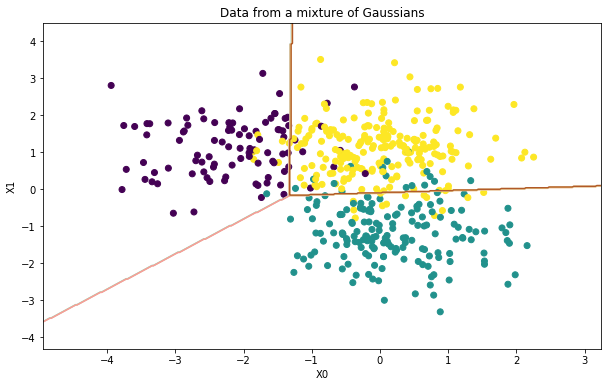

In [16]:
plt.figure(figsize=(10,6))
plt.scatter(data['X0'], data['X1'] ,c = data['Y'])
plt.xlabel('X0')
plt.ylabel('X1')
plt.title('Data from a mixture of Gaussians')
plt.contour(x0mesh, x1mesh, Z, cmap=plt.cm.Paired)
plt.show()


Note that the decision boundaries are a series of straight lines - for some datasets we might find that a straight line is not a sensible choice for a decision boundary; Quadratic Discriminant Analysis, where we replace the shared covariance matrix with an individual covariance matrix for each label, allows us to generate more flexible decision boundaries corresponding to quadratic lines instead of straight ones. 

## As well as the decision boundary, we can view the probability density of the different gaussian distributions at different points

We can see that the point where the density is largest is the centre of the points with the corresponding label in the training set. 

In [17]:
densityMesh0 = [multivariate_normal.pdf(x, myLDA.params[0]['mu'], myLDA.params['Sigma']) for x in meshDF.to_numpy()]

In [18]:
densityMesh0 = np.array(densityMesh0).reshape(x0mesh.shape)

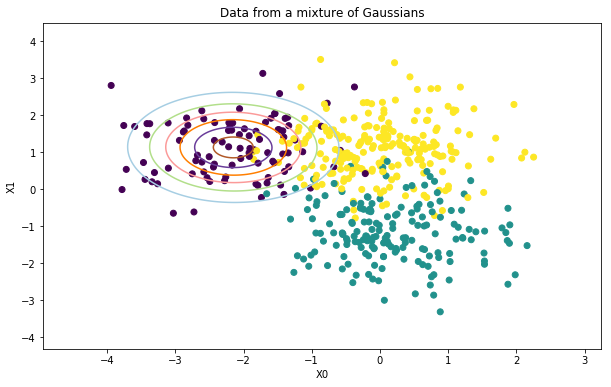

In [19]:
#Conotur plot of the gaussian distribution corresponding to the points with label 0

plt.figure(figsize=(10,6))
plt.scatter(data['X0'], data['X1'] ,c = data['Y'])
plt.xlabel('X0')
plt.ylabel('X1')
plt.title('Data from a mixture of Gaussians')
plt.contour(x0mesh, x1mesh, densityMesh0, cmap=plt.cm.Paired)
plt.show()


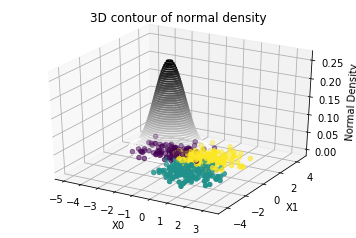

In [20]:
#3D plot of the same

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(data['X0'], data['X1'] ,c = data['Y'])

ax.contour3D(x0mesh, x1mesh, densityMesh0, 50, cmap='binary')
ax.set_xlabel('X0')
ax.set_ylabel('X1')
ax.set_zlabel('Normal Density')
ax.set_title('3D contour of normal density')
plt.show()